**Portfolio Item 2**

We use OpenStreetMap data to examine the Nearest Neighbors algorithm. We use a smaller example to compare its performance to the brute force solution, and then a larger example to examine the distribution of tour lengths over different starting positions

Much of the code used here is referenced from the lecture of Feb 9, though I have replaced some parts with my own code as I found some parts of the provided code difficult to understand.  
I have barely touched the plotting code, but have added my own code for parts of the brute force and Nearest Neighbour implementations.

In [1]:
%pip install osmnx
%pip install contextily

  Using cached osmnx-1.9.1-py3-none-any.whl.metadata (4.9 kB)
Using cached osmnx-1.9.1-py3-none-any.whl (104 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached contextily-1.5.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
Using cached contextily-1.5.0-py3-none-any.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.stats import randint
import numpy as np
import osmnx as ox
import contextily
from itertools import permutations, combinations

We start by pulling data from OpenStreetMap using the `osmnx` package.

We retrieve data from within a bounding box containing a swath of Tokyo's central Chiyoda and Chuo wards.
Coordinates are retrieved from Google Maps.

In [3]:
north = 35.705
south = 35.655
east = 139.777
west = 139.743

G = ox.graph.graph_from_bbox(bbox=(north, south, east, west), network_type='walk')

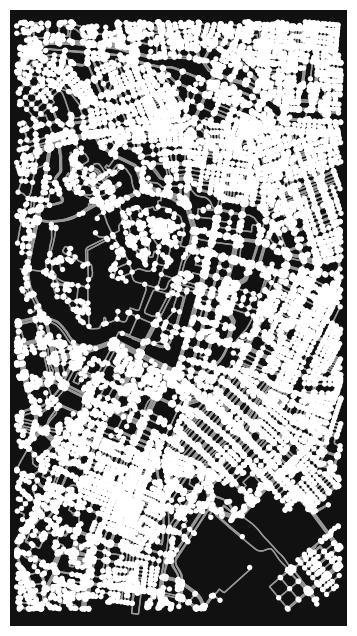

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(G)

We check the size of the node and edge GeoDataFrames.

In [5]:
nodes, edges  = ox.graph_to_gdfs(G)
print(nodes.shape,edges.shape)

(16805, 6) (52474, 15)


We use contextily to plot the graph.

In [6]:
def plot_graph(f,ax,edges):
    edges.plot(linewidth=.25, ax=ax, color='k')
    contextily.add_basemap(ax=ax,
                        crs=edges.crs,
                        source = contextily.providers.CartoDB.Voyager)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

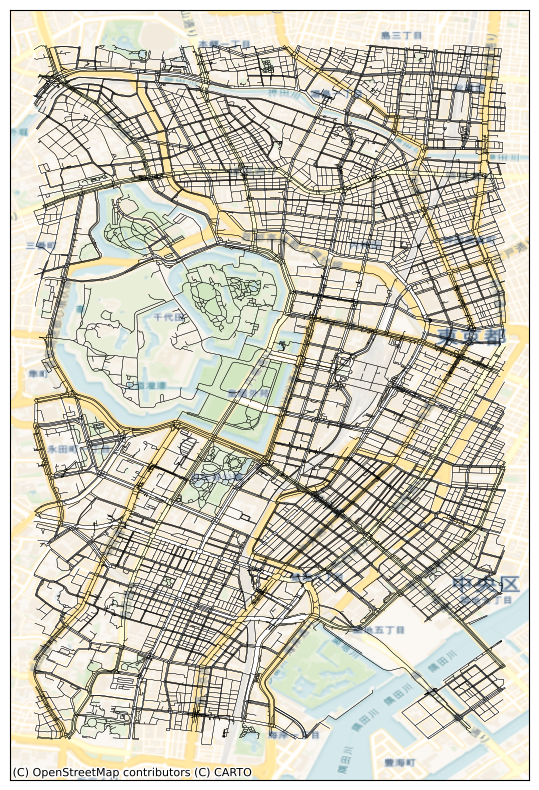

In [7]:
f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)

First, we consider a small example. We manually specify several data points, and compare the brute force solution to the average of Nearest Neighbors run from every starting position.

In [8]:
marunoichi = (35.68161454236161, 139.765493034933)
tokyo_tower = (35.6586283121179, 139.74563297686345)
akihabara = (35.699700927342704, 139.77137400253255)
kokyo_gaien = (35.68011297252292, 139.7583307066725)
nihonbashi = (35.68405758317257, 139.77452280795018)
masakado = (35.687293901539725, 139.76274412604263)
budokan = (35.69331285665947, 139.74975657502853)
destinations = [
    marunoichi,
    tokyo_tower,
    akihabara,
    kokyo_gaien,
    nihonbashi,
    masakado,
    budokan
]
destination_names = [
    "Marunoichi Square",
    "Tokyo Tower",
    "Akihabara",
    "Kokyo Gaien",
    "Nihonbashi Bridge",
    "Grave of Taira no Masakado",
    "Nippon Budokan"
]

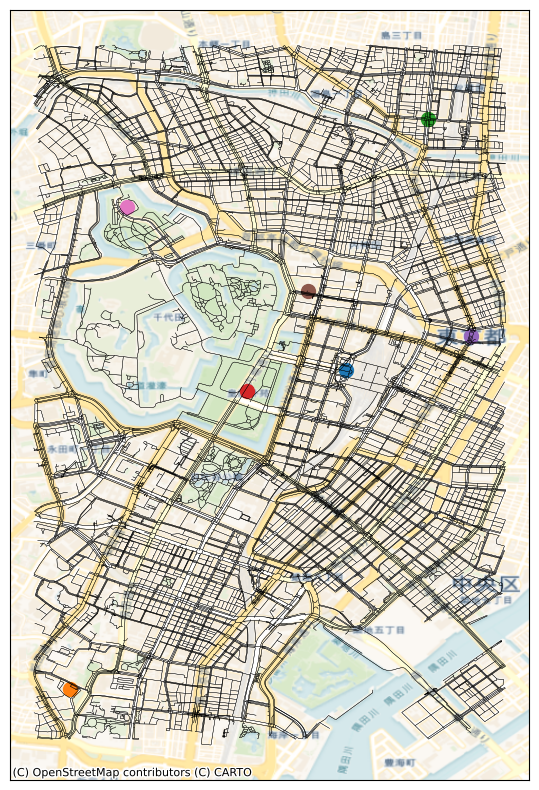

In [9]:
f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)
for point in destinations:
    ax.scatter(point[1],point[0],s=100)

We compute the nearest nodes to each point.

In [10]:
i = 0
destination_nodes = []
while i < len(destinations):
    point = destinations[i]
    destination_nodes.append(ox.distance.nearest_nodes(G, point[1],point[0]))
    i+=1

print(destination_nodes)

[5798366165, 11573378066, 251727197, 6483529437, 5318804773, 8042301662, 5892947313]


For this small example, we can pre-compute the shortest paths between any pair of destinations to make graphing the solution easier.

In [15]:
n = len(destinations)
shortest_paths = {}
shortest_path_lengths = np.zeros((n,n))

for points in permutations(range(n),2):
    node_0 = destination_nodes[points[0]]
    node_1 = destination_nodes[points[1]]
    shortest_paths[points] = nx.shortest_path(G,node_0,node_1,weight='length')
    shortest_path_lengths[points[0],points[1]] = np.round(nx.shortest_path_length(G,node_0,node_1,weight='length'),3)

print(shortest_path_lengths)

[[   0.    3660.184 2271.844  958.617 1091.163  964.413 2397.921]
 [3660.184    0.    5654.879 2931.313 4364.994 3900.504 4835.204]
 [2271.844 5654.879    0.    2815.58  1947.423 1846.982 2686.186]
 [ 958.617 2931.313 2815.58     0.    2021.742  996.871 2137.5  ]
 [1091.163 4364.994 1947.423 2021.742    0.    1301.399 2884.021]
 [ 964.413 3900.504 1846.982  996.871 1301.399    0.    1623.296]
 [2397.921 4835.204 2686.186 2137.5   2884.021 1623.296    0.   ]]


We now have the shortest paths between any two of the destinations.  
We first run a brute force algorithm.  
(Note: this code is mostly my own.)

In [12]:
tours = permutations(range(n))
optimal_tour = None
optimal_tour_length = np.inf

for tour in tours:
    # calculate length of tour
    tour_length = 0
    tour_paths = []
    for i in range(-1, n - 1): # start from -1 to cover the last item in the list
        tour_length += shortest_path_lengths[tour[i],tour[i+1]]
    
    if tour_length < optimal_tour_length:
        optimal_tour = tour
        optimal_tour_length = tour_length
        
tour_named = [destination_names[i] for i in optimal_tour]
print(tour_named)
print(optimal_tour_length)

['Marunoichi Square', 'Tokyo Tower', 'Kokyo Gaien', 'Grave of Taira no Masakado', 'Nippon Budokan', 'Akihabara', 'Nihonbashi Bridge']
14936.436


In [13]:
def get_path_edges(path_nodes,edges):
    edge_list = [(path_nodes[j],path_nodes[j+1]) for j in range(len(path_nodes)-1)]
    return edges[edges.index.isin(edge_list)]

def plot_paths(f,ax,tour,shortest_paths):
    for i in range(len(tour)-1):
        shortest_path_edges = get_path_edges(shortest_paths[(tour[i],tour[i+1])],edges)
        shortest_path_edges.plot(linewidth=3, ax=ax, color='b')
    shortest_path_edges = get_path_edges(shortest_paths[(tour[-1],tour[0])],edges)
    shortest_path_edges.plot(linewidth=3, ax=ax, color='b')

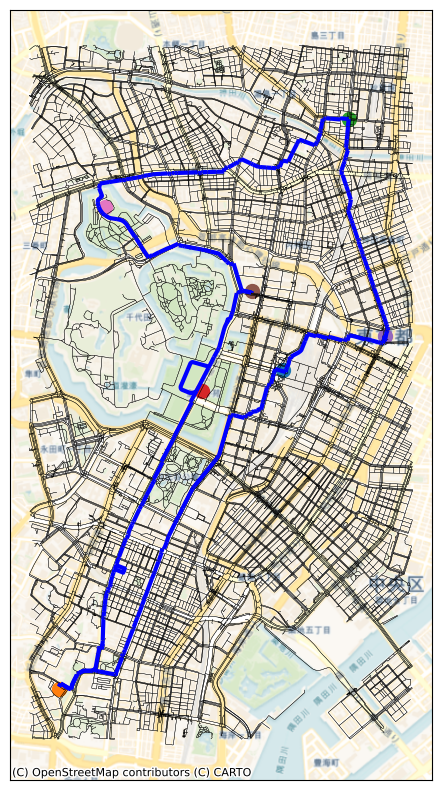

In [16]:
f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)
for point in destinations:
    ax.scatter(point[1],point[0],s=100)
plot_paths(f,ax,optimal_tour,shortest_paths)
plt.show()

We can also examine the nearest neighbour algorithm.  
We start the algorithm at Marunoichi Square.  
(Note: the nearest neighbor code below is mostly my own.)

In [17]:
def nearest_neighbor(start, ):
    curr = start
    nn_tour = [curr]
    nn_tour_length = 0
    
    while len(nn_tour) < n:  
        # get distances to nearest
        dists = shortest_path_lengths[curr,:]
        dist_rank = np.argsort(dists) # list of points in increasing order of distance
        for i in dist_rank:
            if i not in nn_tour: # not yet visited
                nn_tour_length += dists[i]
                nn_tour.append(i)
                curr = i
    # end of tour, add final step
    nn_tour_length += shortest_path_lengths[nn_tour[-1],nn_tour[0]]
    return nn_tour, nn_tour_length

nn_tour, nn_tour_length = nearest_neighbor(0)
print(nn_tour)
print(nn_tour_length)

[0, 3, 5, 4, 2, 6, 1]
15004.326000000001


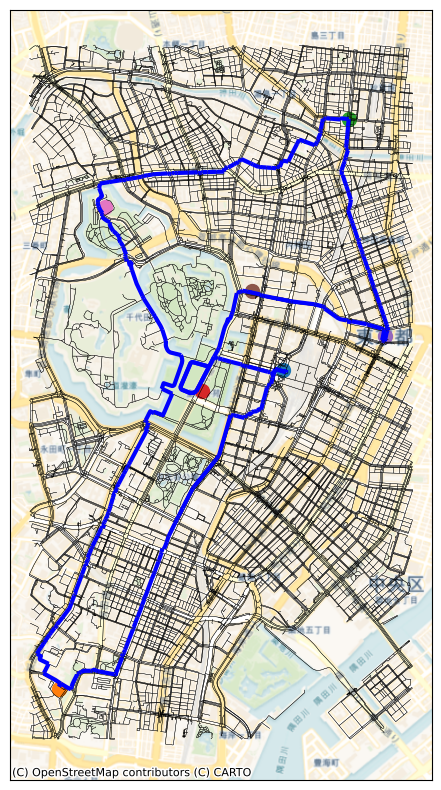

In [18]:
f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)
for point in destinations:
    ax.scatter(point[1],point[0],s=100)
plot_paths(f,ax,nn_tour,shortest_paths)
plt.show()

We can compare the relative lengths of the paths:

In [19]:
nn_tour_length / optimal_tour_length

1.0045452609980052

When started at Marunoichi, the Nearest Neighbours algorithm performs very well, giving a near-optimal response.
This is likely because  Marunoichi just so happens to be near the middle of the data.  
We can try starting the tour at every possible starting point, and then taking the average.

In [22]:
nn_tour_lengths = np.zeros(n)
for i in range(n):
    a,b = nearest_neighbor(i)
    nn_tour_lengths[i] = b

print(nn_tour_lengths)
print(np.mean(nn_tour_lengths))

[15004.326 31001.957 22877.773 14792.936 17975.736 14533.969 21399.332]
19655.147


In [25]:
np.mean(nn_tour_lengths) / optimal_tour_length

1.3159194736950637

Over the average of the 7 points, the Nearest Neighbors algorithm returns a solution about 1.32 times the optimal solution.  

We can consider a larger dataset to examine the variation in the performance of Nearest Neighbors.  
Within the bounding box, we grab 20 random nodes and perform Nearest Neighbors on each.
We find the average and standard deviation of all the data.  
(Any more than 20 points seems to result in very long runtimes.)
(Note: all code below is mostly my own.)

In [62]:
N = 20
rand = randint.rvs(0,nodes.shape[0],size=N,random_state=0) # using seeded values for replicability
rand_nodes = nodes.iloc[rand,:]
print(rand_nodes.head())

                    y           x  street_count   highway  ref  \
osmid                                                            
1475722650  35.657029  139.750418             3       NaN  NaN   
5939150914  35.688311  139.771649             3       NaN  NaN   
5565452727  35.700409  139.776979             4  crossing  NaN   
6279225201  35.658120  139.752715             4       NaN  NaN   
5247201634  35.688263  139.757294             3       NaN  NaN   

                              geometry  
osmid                                   
1475722650  POINT (139.75042 35.65703)  
5939150914  POINT (139.77165 35.68831)  
5565452727  POINT (139.77698 35.70041)  
6279225201  POINT (139.75271 35.65812)  
5247201634  POINT (139.75729 35.68826)  


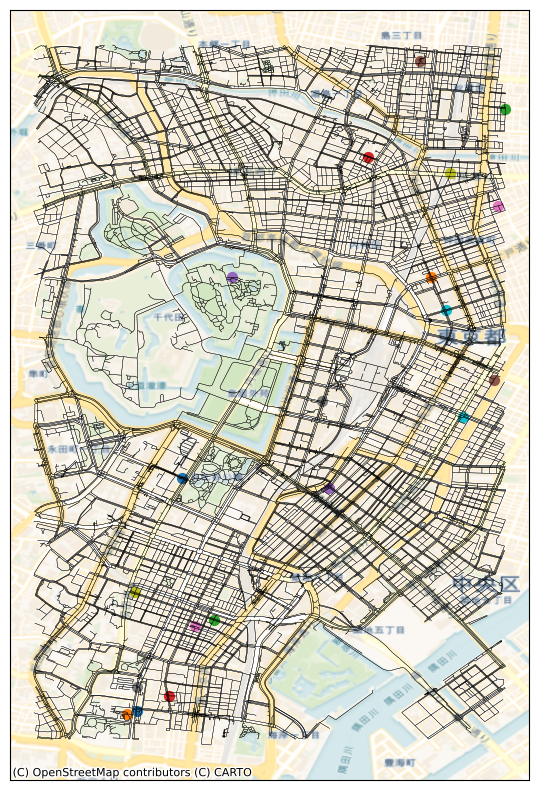

In [63]:
f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)
for node in range(rand_nodes.shape[0]):
    ax.scatter(rand_nodes.iloc[node,1],rand_nodes.iloc[node,0],s=50)

We modify the Nearest Neighbors code to be used with this new dataset.

In [60]:
def nearest_neighbor_loop(points, start):
    curr = start # starting node, must be in points
    nn_tour = [curr.name]
    nn_tour_length = 0
    N = points.shape[0]
    
    while len(nn_tour) < N:  
        # get distances to nearest
        closest = 0 # nearest node
        min_dist = np.inf # distance of closest new point to current point
        for i in range(N):
            node = points.iloc[i,:]
            if node.name in nn_tour: continue
            # need curr to be current NODE
            # using rounded distances to combat problems with inaccuracy in floating-point arithmetic
            dist = np.round(nx.shortest_path_length(G,curr.name,node.name,weight='length'),3)
            if dist < min_dist:
                closest = node
                min_dist = dist
                
        # after iterating, set next point
        nn_tour.append(closest.name)
        nn_tour_length += min_dist
        curr = closest
        
    # end of tour, add final step
    nn_tour_length += np.round(nx.shortest_path_length(G,nn_tour[-1],nn_tour[0],weight='length'),3)
    return nn_tour_length

In [64]:
nn_dists = np.zeros(N)
for i in range(N):
    d = nearest_neighbor_loop(rand_nodes,rand_nodes.iloc[i,:])
    nn_dists[i] = d

print(nn_dists)

[19028.235 18602.657 17866.496 19000.321 18683.934 19353.442 19754.273
 18683.934 18797.413 18683.934 18055.257 19037.719 19728.555 18838.77
 18055.257 17866.496 19028.874 18865.528 17866.496 19362.13 ]


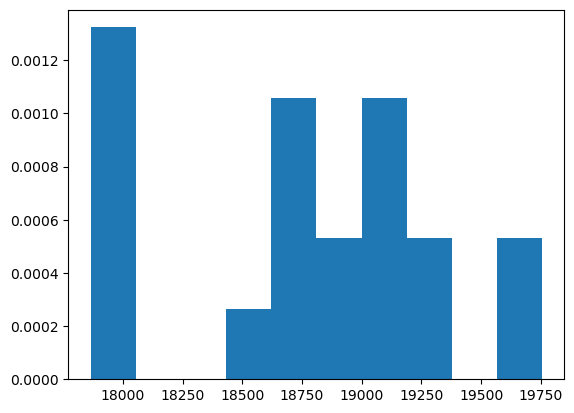

In [65]:
plt.hist(nn_dists,density=True)
plt.show()

The points seem to be clustered around 19000, though the sample size is too small to get a good picture of the distribution.
There is a large spike at around 18000, which may represent that near-optimal configurations are more likely with particular starting points.  
Overall, however, the number of data points is too small to draw meaningful conclusions.
The issue of runtime might be fixable with more efficient code.

**References**

Berry, George. "Travelling SalesPerson and OpenStreetMap". Math 441. Mathematical Modelling: Discrete Optimization Problems. 09 February 2024, University of British Columbia. Lecture.
Cook, William J. et al. *Combinatorial Optimization*. Wiley, 1998.  